In [1]:
%cd 'drive/MyDrive/cARscan'
%ls

/content/drive/MyDrive/cARscan
bad_light/  car_model.h5  images/


In [2]:
# Importing necessary libraries
import os
import numpy as np
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.layers import (Input, Lambda, Conv2D, Dropout, MaxPooling2D, 
                                    Conv2DTranspose, concatenate)

from tensorflow.keras import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K
import tensorflow as tf

In [3]:
# Params
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

In [4]:
TRAIN_PATH = 'images'
TRAINMASKS_PATH = 'masks'
TEST_PATH = ''

train_ids = ['view'+str(i)+'.' for i in range(1,11)]

In [6]:
X = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
y = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

In [10]:
# Train images
print('\nResizing training images and masks')
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):    
    img = imread(TRAIN_PATH+'/'+id_+'/images/'+id_+'jpeg')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X[n] = img
    
    mask = imread(TRAIN_PATH+'/'+id_+'/masks/'+id_+'.png')
    mask = np.expand_dims(resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True),
                              axis=-1)
    y[n] = mask

  0%|          | 0/10 [00:00<?, ?it/s]


Resizing training images and masks


100%|██████████| 10/10 [01:35<00:00,  9.52s/it]


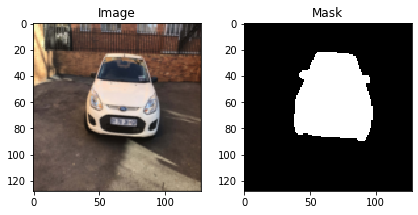

In [11]:
i = 0
plt.subplot(121)
imshow(X[i])
plt.title('Image')
plt.subplot(122)
imshow(np.squeeze(y[i]))
plt.title('Mask')
plt.show()

In [12]:
X = X/255.

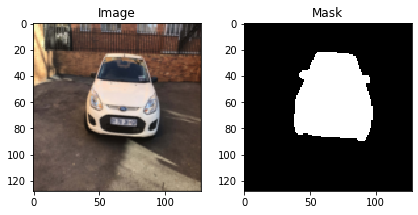

In [13]:
i = 0
plt.subplot(121)
imshow(X[i])
plt.title('Image')
plt.subplot(122)
imshow(np.squeeze(y[i]))
plt.title('Mask')
plt.show()

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [15]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7, 128, 128, 3), (3, 128, 128, 3), (7, 128, 128, 1), (3, 128, 128, 1))

In [38]:
# Inputs
inputs = Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))
# Change integer to float and also scale pixel values
# s = Lambda(lambda x: x/255.0)(inputs)

# Contraction/Encoder path
# Block 1
c1 = Conv2D(filters=16, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs) #(s)
c1 = Dropout(0.1)(c1)
c1 = Conv2D(filters=16, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = MaxPooling2D(pool_size=(2,2))(c1)
# Block 2
c2 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = Dropout(0.1)(c2)
c2 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = MaxPooling2D(pool_size=(2,2))(c2)
# Block 3
c3 = Conv2D(filters=64, kernel_size=(3,3), 
                            activation='relu', kernel_initializer='he_normal',
                           padding='same')(p2)
c3 = Dropout(0.2)(c3)
c3 = Conv2D(filters=64, kernel_size=(3,3), 
                            activation='relu', kernel_initializer='he_normal',
                           padding='same')(c3)
p3 = MaxPooling2D(pool_size=(2,2))(c3)
# Block 4
c4 = Conv2D(filters=128, kernel_size=(3,3), 
                            activation='relu', kernel_initializer='he_normal',
                           padding='same')(p3)
c4 = Dropout(0.2)(c4)
c4 = Conv2D(filters=128, kernel_size=(3,3), 
                            activation='relu', kernel_initializer='he_normal',
                           padding='same')(c4)
p4 = MaxPooling2D(pool_size=(2,2))(c4)
# Block 5
c5 = Conv2D(filters=256, kernel_size=(3,3), 
                            activation='relu', kernel_initializer='he_normal',
                           padding='same')(p4)
c5 = Dropout(0.3)(c5)
c5 = Conv2D(filters=256, kernel_size=(3,3), 
                            activation='relu', kernel_initializer='he_normal',
                           padding='same')(c5)

# Expansion/Decoder path
# Block 6
u6 = Conv2DTranspose(filters=128, kernel_size=(2,2), strides = (2,2), padding='same')(c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(filters=128, kernel_size=(3,3), 
                            activation='relu', kernel_initializer='he_normal',
                           padding='same')(u6)
c6 = Dropout(0.2)(c6)
c6 = Conv2D(filters=128, kernel_size=(3,3), 
                            activation='relu', kernel_initializer='he_normal',
                           padding='same')(c6)

# Block 7
u7 = Conv2DTranspose(filters=64, kernel_size=(2,2), strides = (2,2), padding='same')(c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(filters=64, kernel_size=(3,3), 
                            activation='relu', kernel_initializer='he_normal',
                           padding='same')(u7)
c7 = Dropout(0.2)(c7)
c7 = Conv2D(filters=64, kernel_size=(3,3), 
                            activation='relu', kernel_initializer='he_normal',
                           padding='same')(c7)

# Block 8
u8 = Conv2DTranspose(filters=32, kernel_size=(2,2), strides = (2,2), padding='same')(c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(filters=32, kernel_size=(3,3), 
                            activation='relu', kernel_initializer='he_normal',
                           padding='same')(u8)
c8 = Dropout(0.1)(c8)
c8 = Conv2D(filters=32, kernel_size=(3,3), 
                            activation='relu', kernel_initializer='he_normal',
                           padding='same')(c8)

# Block 9
u9 = Conv2DTranspose(filters=16, kernel_size=(2,2), strides = (2,2), padding='same')(c8)
u9 = concatenate([u9, c1])
c9 = Conv2D(filters=16, kernel_size=(3,3), 
                            activation='relu', kernel_initializer='he_normal',
                           padding='same')(u9)
c9 = Dropout(0.1)(c9)
c9 = Conv2D(filters=16, kernel_size=(3,3), 
                            activation='relu', kernel_initializer='he_normal',
                           padding='same')(c9)
# Outputs
outputs = Conv2D(filters=1, kernel_size=(1,1), 
                            activation='sigmoid')(c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 128, 128, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 128, 128, 16) 0           conv2d_19[0][0]                  
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 128, 128, 16) 2320        dropout_9[0][0]                  
____________________________________________________________________________________________

In [39]:
def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def iou_loss(y_true, y_pred):
    return 1 - iou_coef(y_true, y_pred)

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
    return dice

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [40]:
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = [iou_coef, dice_coef, 'accuracy'])

In [41]:
# Callbacks
callbacks_list = [ModelCheckpoint('car_model.h5', verbose=1, save_best_only=True),
                  EarlyStopping(patience=10, monitor='val_loss')]

In [42]:
tf.config.run_functions_eagerly(True)

In [51]:
model_results = model.fit(X_train, y_train.astype(np.float32), validation_split=0.1, batch_size=32, 
                          epochs=50, callbacks=callbacks_list)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/50
1/1 [==============================] - 1s 1s/step - loss: 0.0680 - iou_coef: 0.8337 - dice_coef: 0.9092 - accuracy: 0.9701 - val_loss: 0.1263 - val_iou_coef: 0.7414 - val_dice_coef: 0.8515 - val_accuracy: 0.9432

Epoch 00001: val_loss did not improve from 0.09263
Epoch 2/50
1/1 [==============================] - 1s 1s/step - loss: 0.0724 - iou_coef: 0.8255 - dice_coef: 0.9041 - accuracy: 0.9694 - val_loss: 0.1043 - val_iou_coef: 0.7688 - val_dice_coef: 0.8693 - val_accuracy: 0.9564

Epoch 00002: val_loss did not improve from 0.09263
Epoch 3/50
1/1 [==============================] - 1s 1s/step - loss: 0.0646 - iou_coef: 0.8369 - dice_coef: 0.9109 - accuracy: 0.9723 - val_loss: 0.0904 - val_iou_coef: 0.7898 - val_dice_coef: 0.8826 - val_accuracy: 0.9631

Epoch 00003: val_loss improved from 0.09263 to 0.09042, saving model to car_model.h5
Epoch 4/50
1/1 [==============================] - 1s 1s/step - loss: 0.0704 - iou_coef: 0.8321 - dice_coef: 0.9081 - accuracy: 0.9699 - val_l

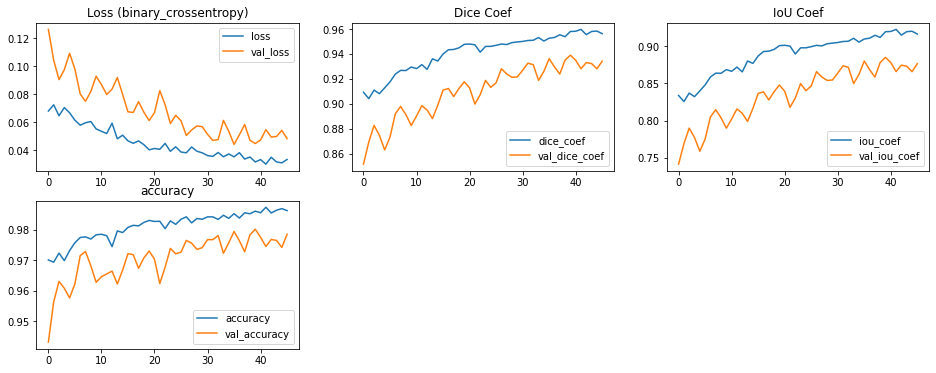

In [52]:
plt.figure(figsize=[16,6])
plt.subplot(231)
plt.plot(model_results.history['loss'], label='loss')
plt.plot(model_results.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss (binary_crossentropy)')
plt.subplot(232)
plt.plot(model_results.history['dice_coef'], label='dice_coef')
plt.plot(model_results.history['val_dice_coef'], label='val_dice_coef')
plt.legend()
plt.title('Dice Coef')
plt.subplot(233)
plt.plot(model_results.history['iou_coef'], label='iou_coef')
plt.plot(model_results.history['val_iou_coef'], label='val_iou_coef')
plt.legend()
plt.title('IoU Coef')
plt.subplot(234)
plt.plot(model_results.history['accuracy'], label='accuracy')
plt.plot(model_results.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.title('accuracy')
plt.show()

In [32]:
#model = load_model('car_model.h5')

In [53]:
print("Evaluate on val data")
results = model.evaluate(X_test, y_test.astype(np.float32))

Evaluate on val data


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


1/1 [==============================] - 0s 206ms/step - loss: 0.0510 - iou_coef: 0.8765 - dice_coef: 0.9342 - accuracy: 0.9787


In [54]:
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
y_true_train = y_train[:int(y_train.shape[0]*0.9)]
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
y_true_val = y_train[int(y_train.shape[0]*0.9):]
preds_test = model.predict(X_test, verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


1/1 [==============================] - 0s 168ms/step


In [55]:
# Thresholding
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

In [56]:
# Show images
def show_images(i, ti, orgimg, y_true, preds, preds_t):
    plt.figure(figsize=(12,8))
    plt.subplot(231)
    imshow(orgimg[i])
    plt.title('Image to be Segmented')
    plt.subplot(232)
    imshow(np.squeeze(y_true[ti]))
    plt.title('Segmentation Ground Truth')
    plt.subplot(233)
    imshow(np.squeeze(preds[ti]))
    plt.title('Predicted Segmentation')
    plt.subplot(234)
    imshow(np.squeeze(preds_t[ti]))
    plt.title('Thresholded Segmentation')

    bgrm = np.zeros((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    bgrm = orgimg[i] * preds_t[ti].astype(dtype=np.float64)
    plt.subplot(235)
    imshow(bgrm)
    plt.title('Background Removed')        
    
    plt.show()

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


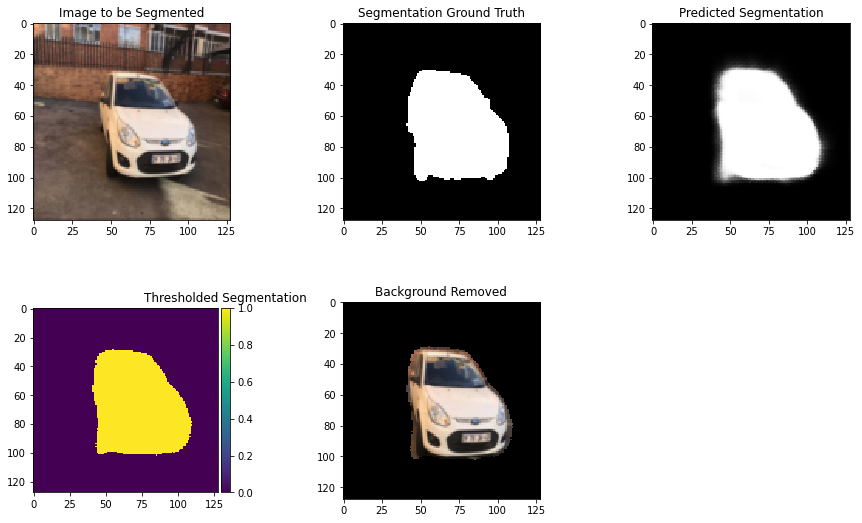

In [57]:
# On Train
# train max 5
i = 5
show_images(i, i, X_train, y_true_train, preds_train, preds_train_t)

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


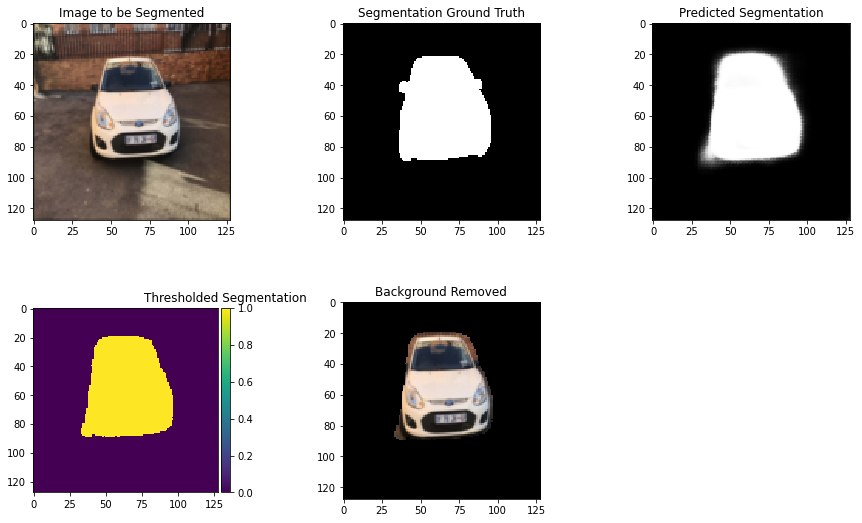

In [58]:
# On Test
i = 1
show_images(i, i, X_test, y_test, preds_test, preds_test_t)

In [ ]:
np.max(preds_train_t)

0

In [68]:
preds = model.predict(X)
preds_t = (preds > 0.5).astype(np.uint8)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


In [73]:
from skimage.io import imsave
import os

for i in range(1, 11):   
  bgrm = X[i-1] * preds_t[i-1].astype(dtype=np.float64)
  
  os.makedirs(f'images/view{i}./predMask', exist_ok=True)
  filename = f'images/view{i}./predMask/view{i}.jpeg'
  imsave(filename, preds[i-1])

  os.makedirs(f'images/view{i}./predThresMask', exist_ok=True)
  filename = f'images/view{i}./predThresMask/view{i}.jpeg'
  imsave(filename, preds_t[i-1]*255)

  os.makedirs(f'images/view{i}./bgrm', exist_ok=True)
  filename = f'images/view{i}./bgrm/view{i}.jpeg'
  imsave(filename, bgrm)
  
